# SINet COD10K Detection
Implementazione migliorata di SINet per il rilevamento di oggetti mimetizzati.

In [226]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import os
from PIL import Image
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F

In [227]:
# device = torch.device('cuda')
device = torch.device('mps')

In [228]:
class CODDataset(Dataset):
    def __init__(self, image_folder, mask_folder,
                 image_transform=None, mask_transform=None):
        self.image_files = os.listdir(image_folder)
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_folder, self.image_files[idx])
        mask_path = os.path.join(self.mask_folder, self.image_files[idx].replace('.jpg', '.png'))

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        return image, mask

    def __len__(self):
        return len(self.image_files)

In [229]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return F_loss.mean() if self.reduction == 'mean' else F_loss.sum()

In [230]:
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
    # transforms.RandomRotation(15),
    # transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.GaussianBlur(kernel_size=(3, 3)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

mask_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
    # transforms.RandomRotation(15),
    transforms.GaussianBlur(kernel_size=(3, 3)),
    transforms.ToTensor()
])


In [231]:
train_dataset = CODDataset(
    image_folder="COD10K-v3/Train/Image",
    mask_folder="COD10K-v3/Train/GT_Object",
    image_transform=image_transform,
    mask_transform=mask_transform
)

test_dataset = CODDataset("COD10K-v3/Test/Image",
                          "COD10K-v3/Test/GT_Object",
                          image_transform=image_transform, 
                          mask_transform=mask_transform
                          )

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0, pin_memory=True)

In [232]:
class SINet(nn.Module):
    def __init__(self):
        super(SINet, self).__init__()
        self.backbone = models.efficientnet_b4(weights=models.EfficientNet_B4_Weights.DEFAULT)
        self.backbone_features = self.backbone.features
        self.edge_attention = nn.Sequential(
            nn.Conv2d(1792, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 1, kernel_size=1),
            nn.Sigmoid()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1792 + 256, 512, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        features = self.backbone_features(x)
        edge_map = self.edge_attention(features)
        edge_map = torch.nn.functional.interpolate(edge_map, size=features.shape[2:], mode='bilinear', align_corners=False)
        combined = torch.cat((features, edge_map.expand(-1, 256, -1, -1)), dim=1)
        output = self.decoder(combined)
        return output

In [233]:
model = SINet().to(device)
criterion = FocalLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-6)

In [234]:
for epoch in range(15):
    model.train()
    total_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        preds = model(images)
        preds = nn.functional.interpolate(preds, size=masks.shape[2:], mode='bilinear', align_corners=False)
        loss = criterion(preds, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    scheduler.step()
    print(f'Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}')

Epoch 1, Loss: 0.0139
Epoch 2, Loss: 0.0112
Epoch 3, Loss: 0.0100
Epoch 4, Loss: 0.0099
Epoch 5, Loss: 0.0098
Epoch 6, Loss: 0.0097
Epoch 7, Loss: 0.0093
Epoch 8, Loss: 0.0094
Epoch 9, Loss: 0.0092
Epoch 10, Loss: 0.0089
Epoch 11, Loss: 0.0086
Epoch 12, Loss: 0.0082
Epoch 13, Loss: 0.0080
Epoch 14, Loss: 0.0075
Epoch 15, Loss: 0.0073


In [235]:
torch.save(model.state_dict(), 'sinet_cod_model.pth')

# state_dict = torch.load('sinet_cod_model.pth')  # carica l'OrderedDict con i pesi
# model.load_state_dict(state_dict)               # popola i pesi
# model.eval()                

In [236]:
# def compute_iou(mask_np, pred_np):
#     if mask_np.sum() == 0:
#         return None
#     return jaccard_score(mask_np, pred_np, zero_division=1)

# def visualize_predictions(model, dataloader, num_images=10):
#     model.eval()
#     iou_scores = []
#     with torch.no_grad():
#         for i, (image, mask) in enumerate(dataloader):
#             if i >= num_images:
#                 break
#             # image = image.unsqueeze(0).to(device)
#             image = image.unsqueeze(0).to(device)
#             mask = mask.to(device)
#             pred = model(image)
#             pred = (pred > 0.5).float()
#             mask_np = (mask.squeeze().cpu().numpy() > 0.5).astype(int)
#             pred_np = (pred.squeeze().cpu().numpy() > 0.5).astype(int)
#             iou = compute_iou(mask_np, pred_np)
#             if iou is not None:
#                 iou_scores.append(iou)
#     print(f"Mean IoU (filtered): {sum(iou_scores) / len(iou_scores):.2f}")
    
# visualize_predictions(model, test_loader, num_images=10)

In [237]:
import torch
import torch.nn.functional as F
from sklearn.metrics import jaccard_score
import numpy as np

def evaluate_model(model, dataloader, device):
    model.eval()
    iou_scores = []
    with torch.no_grad():
        for images, masks in dataloader:
            # images: [B, 3, H, W], masks: [B, 1, H, W]
            images = images.to(device)
            masks = masks.to(device)

            preds = model(images)  # [B, 1, H', W']
            # Ridimensiona le predizioni alla stessa dimensione delle maschere
            preds = F.interpolate(preds, size=masks.shape[2:], mode='bilinear', align_corners=False)
            
            # Binarizza le predizioni
            preds_bin = (preds > 0.5).float()
            
            # Calcola IoU per ogni immagine nel batch
            # dobbiamo portarci tutto su CPU e in numpy
            preds_np = preds_bin.squeeze(1).cpu().numpy().astype(np.uint8)  # shape [B, H, W]
            masks_np = masks.squeeze(1).cpu().numpy().astype(np.uint8)      # shape [B, H, W]

            for p, m in zip(preds_np, masks_np):
                # Flatten per jaccard_score di sklearn
                p_flat = p.flatten()
                m_flat = m.flatten()

                # Se la maschera è completamente vuota, jaccard_score da 0 se p è non vuota
                # oppure 1 se p anche vuota. Ci sono vari modi di gestire il corner-case.
                # Per semplicità ignoriamo i casi in cui la mask è interamente 0 se lo desideri.
                # Oppure calcoliamo la metrica come di default:
                iou = jaccard_score(m_flat, p_flat, zero_division=1)
                iou_scores.append(iou)

    # Calcoliamo la media delle IoU
    mean_iou = np.mean(iou_scores)
    return mean_iou


In [238]:
# import numpy as np
# import torch
# import torch.nn.functional as F
# import matplotlib.pyplot as plt

def visualize_random_samples(model, dataset, device, num_images=8):
    """
    Pesca `num_images` campioni random dal `dataset`,
    fa la predizione e visualizza (input, mask, prediction).
    """
    model.eval()

    # Estraggo `num_images` indici casuali senza rimpiazzo
    random_indices = np.random.choice(len(dataset), size=num_images, replace=False)

    # List per accumulare tensori
    images_list = []
    masks_list = []

    for idx in random_indices:
        image, mask = dataset[idx]  # <--- CODDataset.__getitem__(idx)
        images_list.append(image)
        masks_list.append(mask)

    # Stack su dimensione batch
    images_tensor = torch.stack(images_list, dim=0).to(device)
    masks_tensor = torch.stack(masks_list, dim=0).to(device)

    with torch.no_grad():
        preds = model(images_tensor)  # shape [B, 1, H', W']
        # Ridimensiona alla dimensione delle maschere
        preds = F.interpolate(preds, size=masks_tensor.shape[2:], mode='bilinear', align_corners=False)
        preds_bin = (preds > 0.5).float()

    images_cpu = images_tensor.cpu()
    masks_cpu = masks_tensor.cpu()
    preds_cpu = preds_bin.cpu()

    fig, axes = plt.subplots(nrows=num_images, ncols=3, figsize=(9, 3*num_images))
    if num_images == 1:
        axes = [axes]

    for i in range(num_images):
        img_np = images_cpu[i].permute(1, 2, 0).numpy()
        mask_np = masks_cpu[i].squeeze(0).numpy()
        pred_np = preds_cpu[i].squeeze(0).numpy()

        axes[i][0].imshow(img_np)
        axes[i][0].set_title("Input Image")
        axes[i][0].axis("off")

        axes[i][1].imshow(mask_np, cmap='gray')
        axes[i][1].set_title("Ground Truth")
        axes[i][1].axis("off")

        axes[i][2].imshow(pred_np, cmap='gray')
        axes[i][2].set_title("Prediction")
        axes[i][2].axis("off")

    plt.tight_layout()
    plt.show()


Test Mean IoU: 0.5686


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


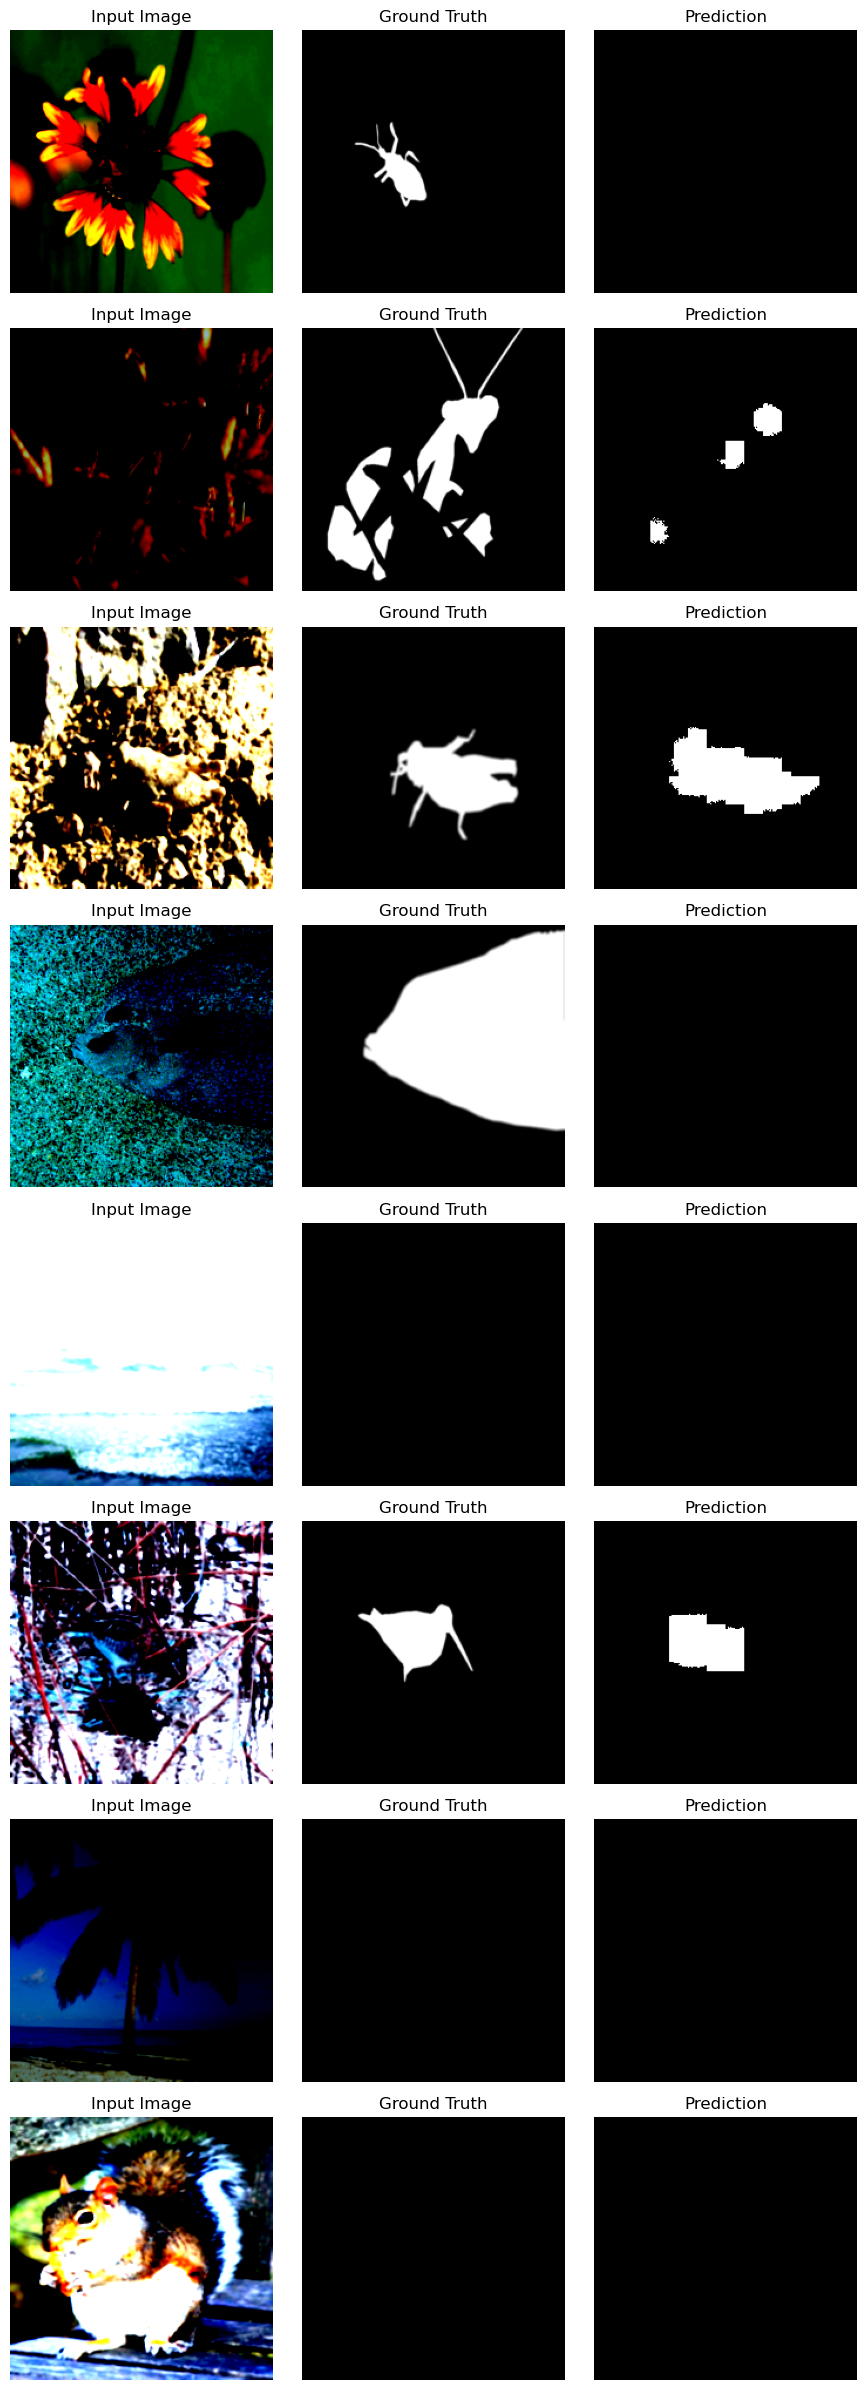

In [241]:
# Esegui una valutazione su test_loader
mean_iou = evaluate_model(model, test_loader, device)
print(f"Test Mean IoU: {mean_iou:.4f}")

# Visualizza alcune predizioni
# visualize_predictions(model, test_loader, device, num_images=8)
visualize_random_samples(model, test_dataset, device, num_images=8)